Student Name: Christian Jones

Student ID: 23294876

# Dataset: Medical Costs billed by Health Insurance
## Import libraries

In [88]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (MinMaxScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Task 2: Regression

Train three regression pipelines with Random Forest, Linear Regression and MLPRegressor as the final estimator, respectively, for predicting the value of `insurance_cost`.

1. Include data preparation and dimensionality reduction steps in the main pipeline.
3. For the dimensionality reduction step use PCA, RFE and select K best.
4. Use grid search for hyperparameter tuning and evaluate the models and pick the best one.
5. Summarise your experience in a markdown cell (max 150 words in a markdown cell).

## EDA

The preprocessing applied here will be very similar to what was done for classification, however instead of converting insurance_cost to a binary value, we will retain the insurance_cost as is, and apply scaling.

In [89]:
df = pd.read_csv("./insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [90]:
# replace smoker: yes/no with 1/0
df['smoker'] = df['smoker'].replace({'yes': 1, 'no': 0})
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,0,northeast,16069.08475
1334,64,female,26.885,0,1,northwest,29330.98315
1335,64,male,26.410,0,0,northeast,14394.55790
1336,64,male,36.960,2,1,southeast,49577.66240
1337,64,male,23.760,0,1,southeast,26926.51440


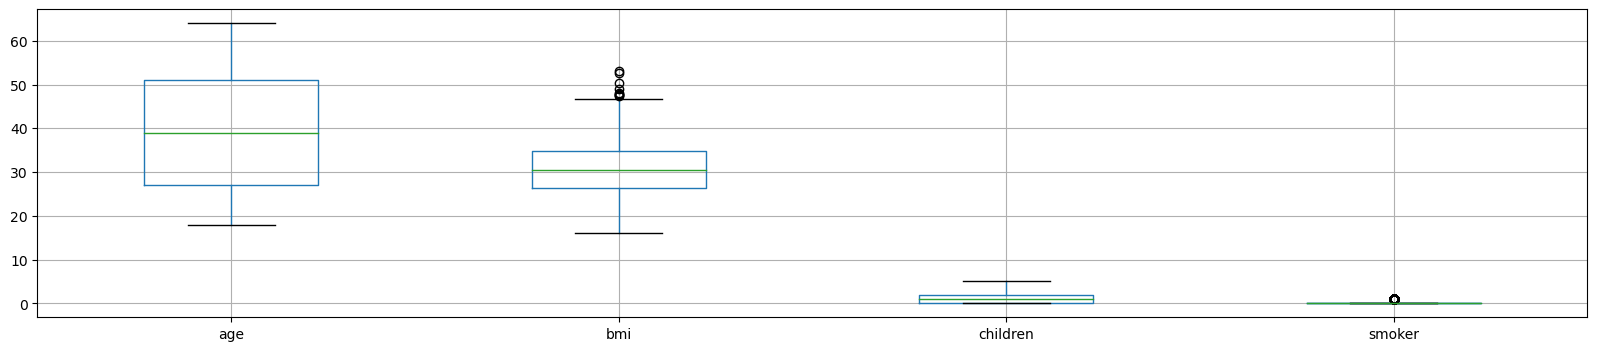

In [91]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20, 4))
plt.show()

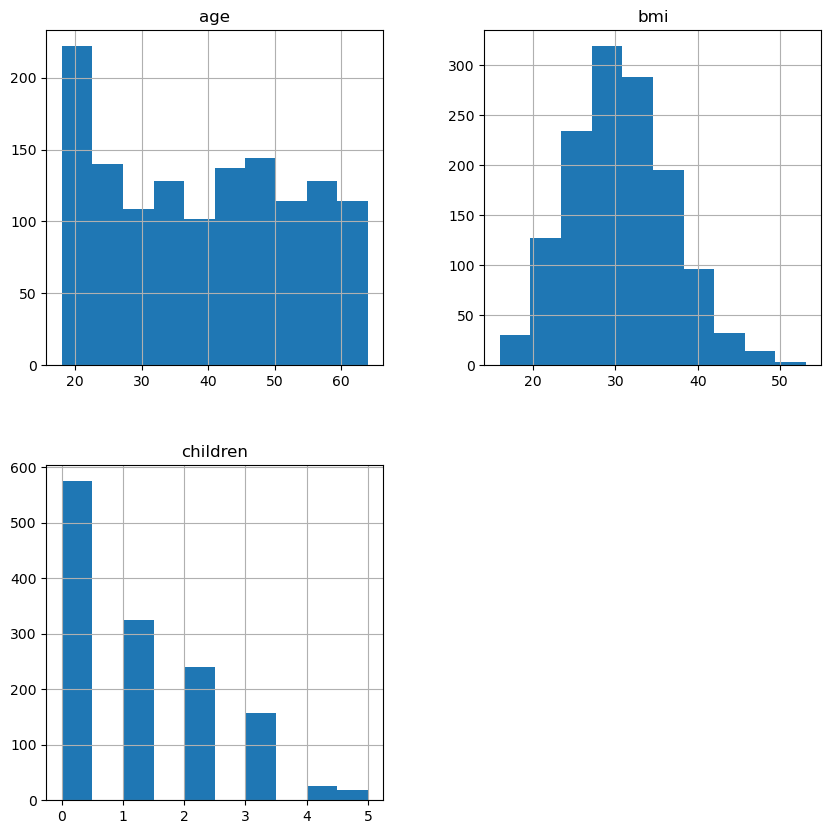

In [92]:
df.drop(['insurance_cost', 'smoker'], axis=1).hist(bins=10, figsize=(10,10));

In [93]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [95]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ('scale', MinMaxScaler(), ['age', 'bmi', 'children']),
        ('encode_gender', OneHotEncoder(drop='first', sparse_output=False), ['gender', 'region'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

## Using Grid Search to Determine Best Parameters for Random Forest, Linear and MLP regression methods

### Random Forest Regression

In [96]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [97]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.853:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'ttr__regressor__max_depth': 6}


### Linear Regression

In [98]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [99]:
N_FEATURES_OPTIONS = [2, 6, 11]
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.535:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=2), 'reduce_dim__n_features_to_select': 2, 'ttr__regressor__fit_intercept': True}


### MLP Regressor

In [100]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                          ('ttr', TransformedTargetRegressor(
                            regressor=MLPRegressor(max_iter=500),
                            func=np.log, 
                            inverse_func=np.exp)
                          )
                      ]
               )

In [101]:
N_FEATURES_OPTIONS = [2, 6, 11]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    },
    {
        'ttr__regressor__hidden_layer_sizes': [(100,), (50, 50), (100, 50, 100)],
        'ttr__regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
        'ttr__regressor__solver': ['lbfgs', 'sgd', 'adam'],
        'ttr__regressor__alpha': [0.0001, 0.001, 0.01],
        'ttr__regressor__learning_rate': ['constant', 'invscaling', 'adaptive'],
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

/Users/christianjones/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/christianjones/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/christianjones/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/christianjones/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best CV score = 0.832:
Best parameters:  {'ttr__regressor__activation': 'logistic', 'ttr__regressor__alpha': 0.001, 'ttr__regressor__hidden_layer_sizes': (50, 50), 'ttr__regressor__learning_rate': 'invscaling', 'ttr__regressor__solver': 'lbfgs'}


Note MLP took 2.5 minutes to run and achieved a CV score of 0.832, optimal hyperparameters highlighted in bold:


hidden_layer_sizes': [(100,), **(50, 50)**, (100, 50, 100)],

activation': ['identity', '**logistic**', 'tanh', 'relu'],

solver': ['**lbfgs**', 'sgd', 'adam'],

alpha': [0.0001, **0.001**, 0.01],

learning_rate': ['constant', '**invscaling**', 'adaptive'],

### Comparison

There is a significant difference in performance between the Random Forest Classifier and Linear Regression models, with CV scores of 0.857 and 0.533, respectively.

In [102]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [103]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
MLP_mse, MLP_mae, MLP_r2 = evaluate_model(X_test, y_test, MLP_best_model)

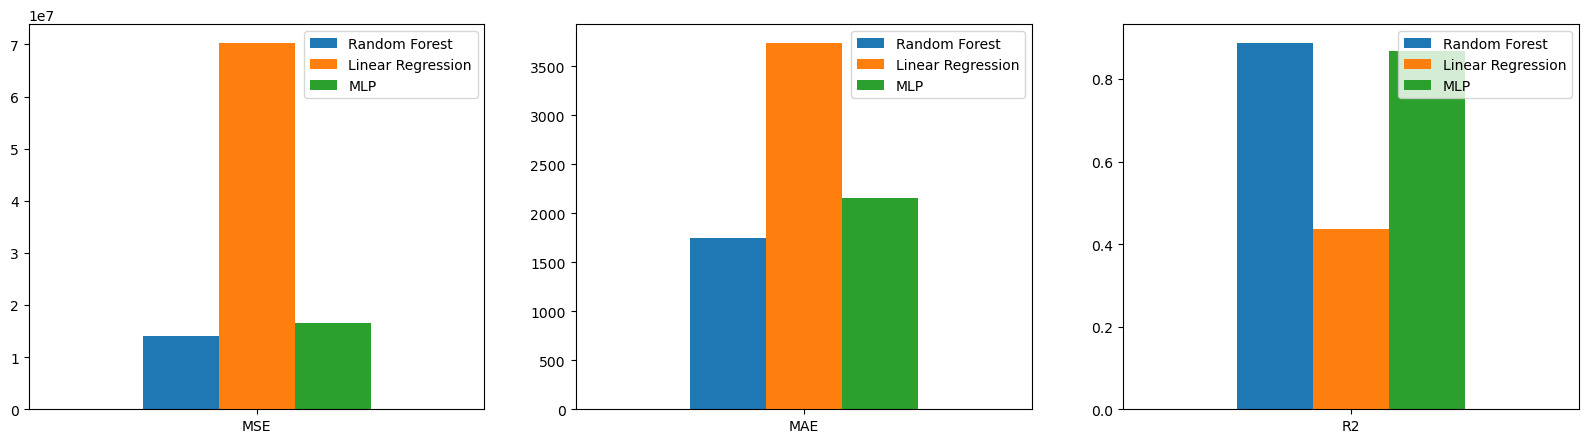

In [105]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'MLP': MLP_mse }, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'MLP': MLP_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'MLP': MLP_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

By comparing MSE, MAE and R2, we see that Random Forest and MLP are comparable, with Linear Regression performing signficantly worse in all three metrics (favouring low mean squared/absolute error and high ROC).